# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [58]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

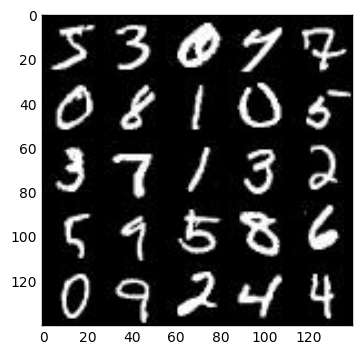

In [59]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

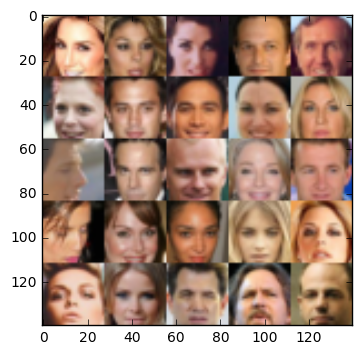

In [60]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\VadymSerpak\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [62]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    l_rate = tf.placeholder(tf.float32, shape=[])

    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [63]:
def discriminator(images, reuse=False):
    
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):

        conv = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        conv = tf.nn.relu(conv)
        # Image size 14x14x64
        
        conv = tf.layers.conv2d(images, 512, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        conv = tf.nn.relu(conv)
        # Image size 7x7x256
        
        logits = tf.reshape(conv, [-1, 7*7*512])
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=(not is_train)):
        conv_t = tf.layers.dense(z, 7*7*512)
        conv_t = tf.reshape(conv_t, [-1, 7, 7, 512])
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        conv_t = tf.nn.relu(conv_t)
        # Image size 7x7x256
        
        conv_t = tf.layers.conv2d_transpose(conv_t, 128, 5, strides=2, padding='same')
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        conv_t = tf.nn.relu(conv_t)
        # Image size 14x14x128
        
        conv_t = tf.layers.conv2d_transpose(conv_t, out_channel_dim, 5, strides=2, padding='same')
        # Image size 28x28xOut_channel_dim
        
        out = tf.tanh(conv_t) # Output
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [92]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 25
    out_channel_dim = len(data_image_mode)
    
    input_real, input_z, learn_r = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_r, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_count, batch_images in enumerate(get_batches(batch_size)):
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})

                if (batch_count % print_every) == 0: 
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    if (batch_count % (print_every*10)) == 0: 
                        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                        
                    print("Time {}... Epoch {}/{}... Batch {}...".format(time.strftime('%X'), epoch_i+1, epoch_count, batch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    
        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

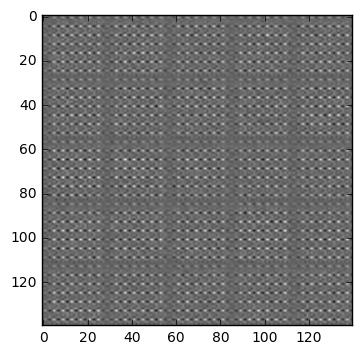

Time 16:54:18... Epoch 1/2... Batch 0... Discriminator Loss: 1.3242... Generator Loss: 0.7263
Time 16:55:43... Epoch 1/2... Batch 25... Discriminator Loss: 1.4658... Generator Loss: 0.5695
Time 16:57:17... Epoch 1/2... Batch 50... Discriminator Loss: 1.4041... Generator Loss: 0.6732
Time 16:58:50... Epoch 1/2... Batch 75... Discriminator Loss: 1.3929... Generator Loss: 0.6856
Time 17:00:24... Epoch 1/2... Batch 100... Discriminator Loss: 1.3756... Generator Loss: 0.6766
Time 17:01:58... Epoch 1/2... Batch 125... Discriminator Loss: 1.3873... Generator Loss: 0.6878
Time 17:03:33... Epoch 1/2... Batch 150... Discriminator Loss: 1.3850... Generator Loss: 0.7012
Time 17:05:09... Epoch 1/2... Batch 175... Discriminator Loss: 1.3788... Generator Loss: 0.6973
Time 17:06:45... Epoch 1/2... Batch 200... Discriminator Loss: 1.3847... Generator Loss: 0.6911
Time 17:08:20... Epoch 1/2... Batch 225... Discriminator Loss: 1.3690... Generator Loss: 0.7463


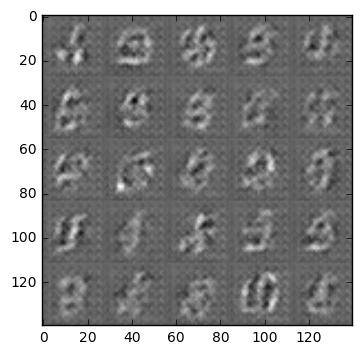

Time 17:09:58... Epoch 1/2... Batch 250... Discriminator Loss: 1.3867... Generator Loss: 0.7000
Time 17:11:35... Epoch 1/2... Batch 275... Discriminator Loss: 1.3795... Generator Loss: 0.6913
Time 17:13:13... Epoch 1/2... Batch 300... Discriminator Loss: 1.3785... Generator Loss: 0.6936
Time 17:14:49... Epoch 1/2... Batch 325... Discriminator Loss: 1.3758... Generator Loss: 0.7132
Time 17:16:25... Epoch 1/2... Batch 350... Discriminator Loss: 1.3671... Generator Loss: 0.6924
Time 17:18:02... Epoch 1/2... Batch 375... Discriminator Loss: 1.3659... Generator Loss: 0.6978
Time 17:19:38... Epoch 1/2... Batch 400... Discriminator Loss: 1.3816... Generator Loss: 0.6939
Time 17:21:15... Epoch 1/2... Batch 425... Discriminator Loss: 1.3711... Generator Loss: 0.6887
Time 17:22:51... Epoch 1/2... Batch 450... Discriminator Loss: 1.3634... Generator Loss: 0.7142
Time 17:24:27... Epoch 1/2... Batch 475... Discriminator Loss: 1.3681... Generator Loss: 0.7122


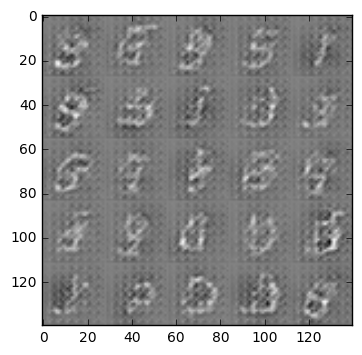

Time 17:26:04... Epoch 1/2... Batch 500... Discriminator Loss: 1.3663... Generator Loss: 0.7039
Time 17:27:41... Epoch 1/2... Batch 525... Discriminator Loss: 1.3701... Generator Loss: 0.7105


KeyboardInterrupt: 

In [93]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

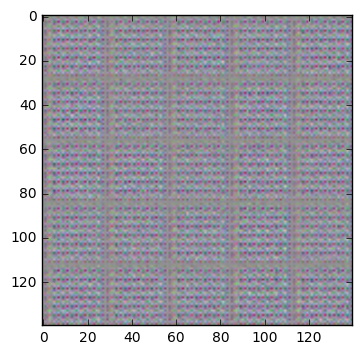

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7233


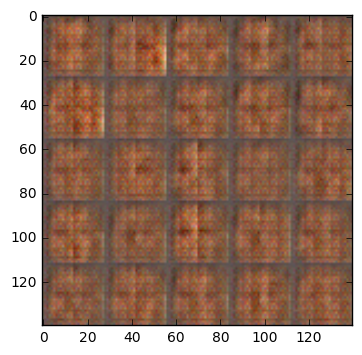

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7084


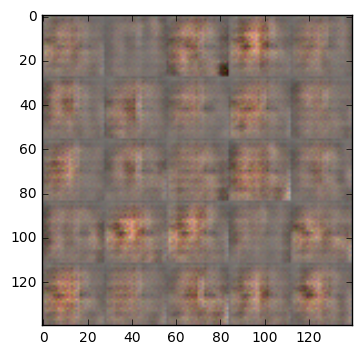

Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6453


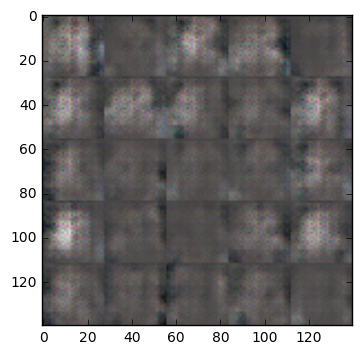

Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6794


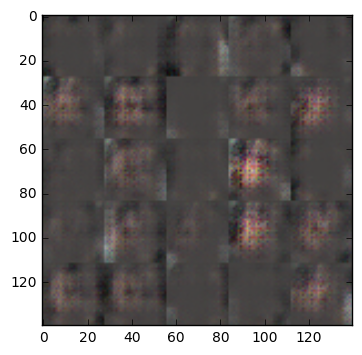

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7471


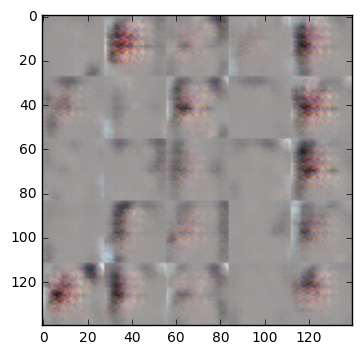

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6955


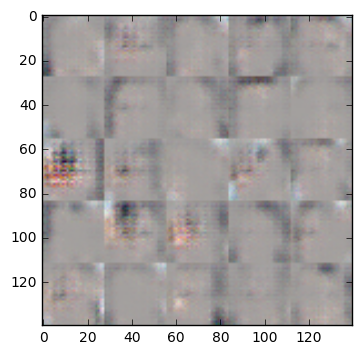

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6981


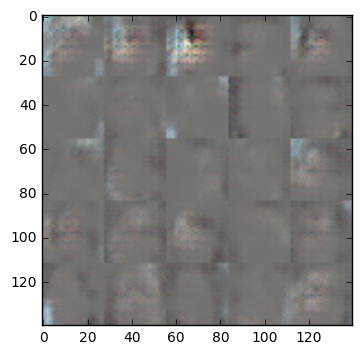

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6929


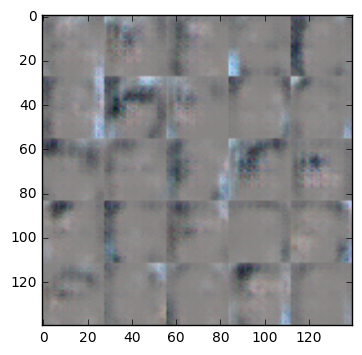

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7062


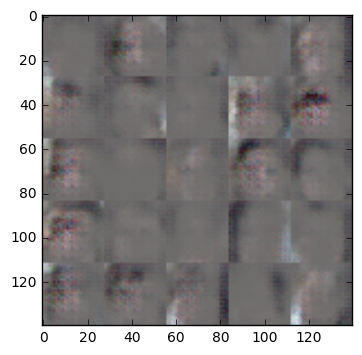

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7004


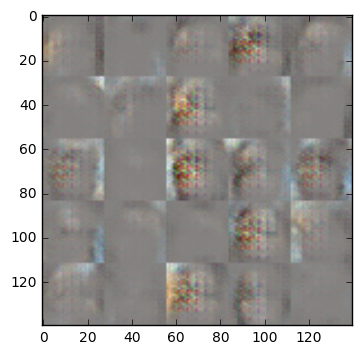

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6886


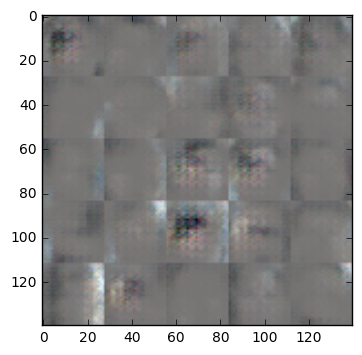

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7042


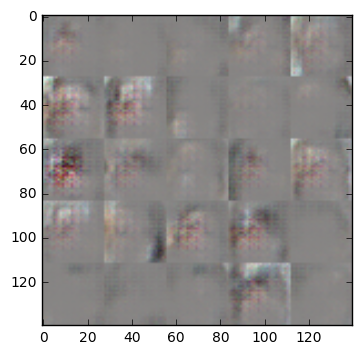

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6918


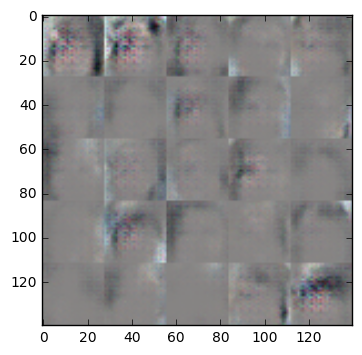

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7035


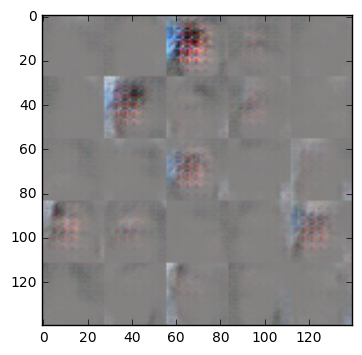

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6853


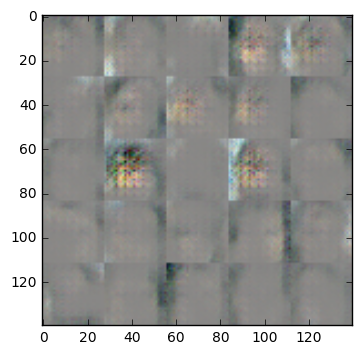

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6915


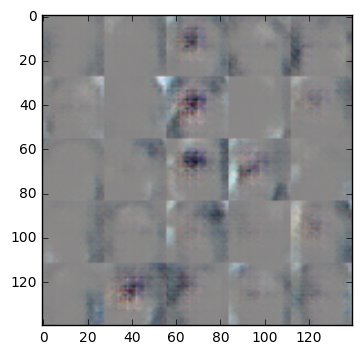

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7100


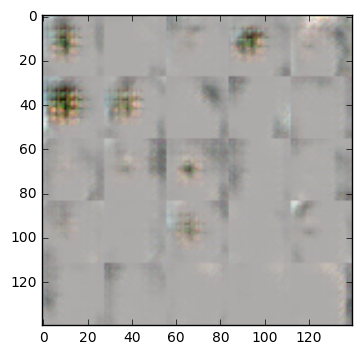

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6864


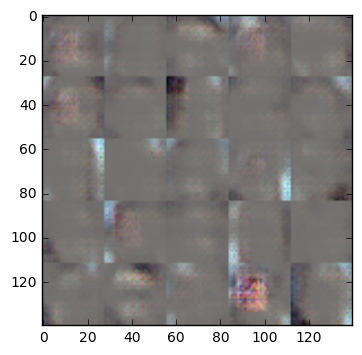

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6974


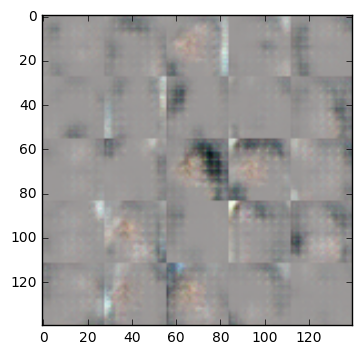

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6924


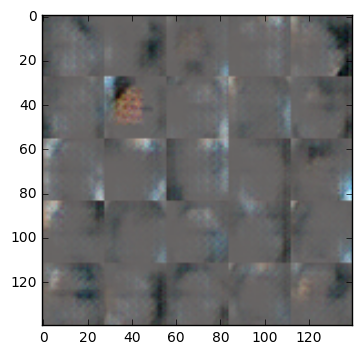

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6899


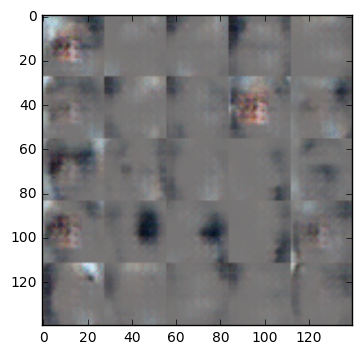

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6913


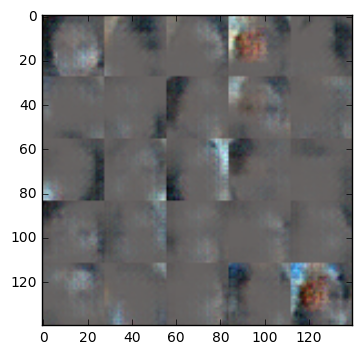

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6939


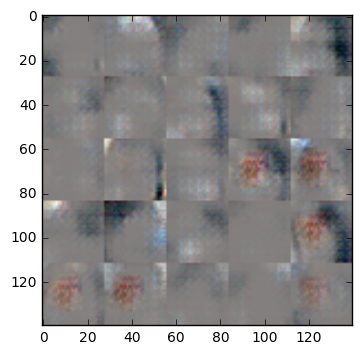

Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6929


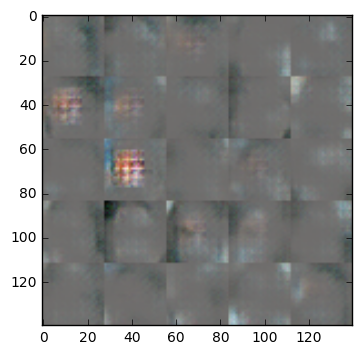

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7232


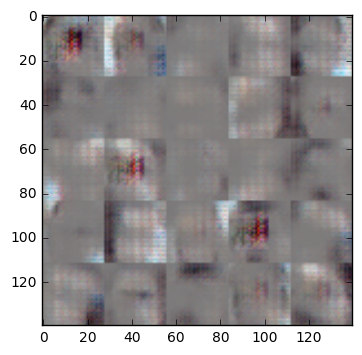

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6732


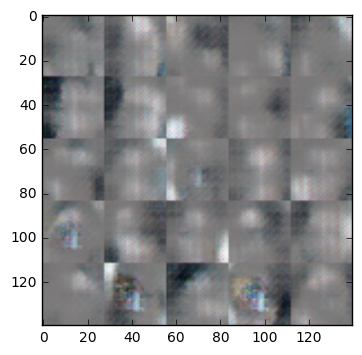

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6995


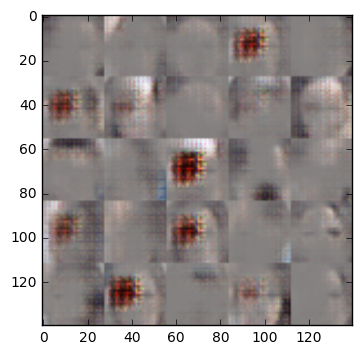

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7092


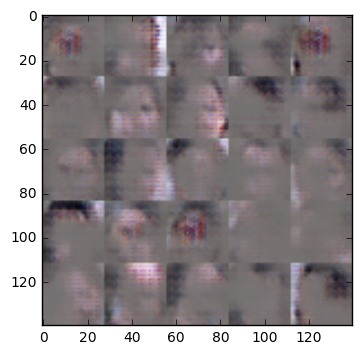

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7033


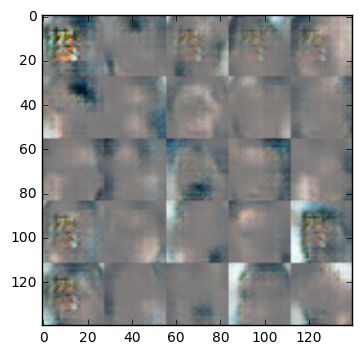

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6973


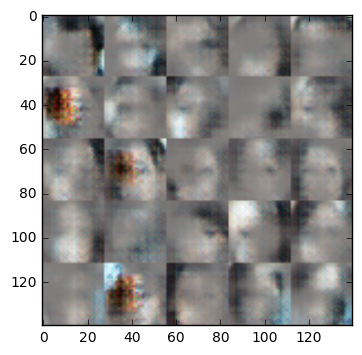

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6996


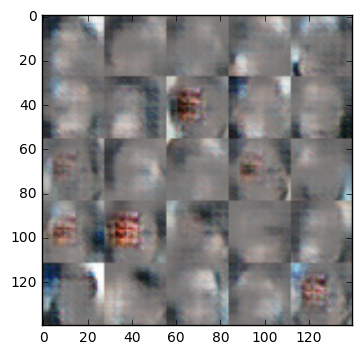

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6956


In [52]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.